In [25]:
import os
import cv2
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# Set your paths
train_path = "/content/drive/MyDrive/Dataset/Train"
test_path = "/content/drive/MyDrive/Dataset/Test"

# Parameters
image_size = (64, 64)  # Resize images to 64x64

def load_images_from_folder(folder, label):
    features = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, image_size)
            img_flat = img.flatten()  # Convert to 1D feature vector
            features.append(img_flat)
            labels.append(label)
    return features, labels

# Load training data
X_train_cat, y_train_cat = load_images_from_folder(os.path.join(train_path, "Cat"), 0)
X_train_dog, y_train_dog = load_images_from_folder(os.path.join(train_path, "Dog"), 1)

# Load test data
X_test_cat, y_test_cat = load_images_from_folder(os.path.join(test_path, "Cat"), 0)
X_test_dog, y_test_dog = load_images_from_folder(os.path.join(test_path, "Dog"), 1)

# Combine train and test
X_train = np.array(X_train_cat + X_train_dog)
y_train = np.array(y_train_cat + y_train_dog)
X_test = np.array(X_test_cat + X_test_dog)
y_test = np.array(y_test_cat + y_test_dog)

# Train KNN model
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Predict and evaluate
y_pred = knn.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))



Accuracy: 0.576271186440678
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.69      0.62        29
           1       0.61      0.47      0.53        30

    accuracy                           0.58        59
   macro avg       0.58      0.58      0.57        59
weighted avg       0.58      0.58      0.57        59



In [26]:
from skimage.feature import hog
from skimage import color

def extract_hog_features(folder, label):
    features = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, image_size)
            gray = color.rgb2gray(img)
            hog_feature = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2), block_norm='L2-Hys')
            features.append(hog_feature)
            labels.append(label)
    return features, labels

# Load HOG features for training and testing
X_train_cat, y_train_cat = extract_hog_features(os.path.join(train_path, "Cat"), 0)
X_train_dog, y_train_dog = extract_hog_features(os.path.join(train_path, "Dog"), 1)

X_test_cat, y_test_cat = extract_hog_features(os.path.join(test_path, "Cat"), 0)
X_test_dog, y_test_dog = extract_hog_features(os.path.join(test_path, "Dog"), 1)

# Combine
X_train = np.array(X_train_cat + X_train_dog)
y_train = np.array(y_train_cat + y_train_dog)
X_test = np.array(X_test_cat + X_test_dog)
y_test = np.array(y_test_cat + y_test_dog)

# Train KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Predict
y_pred = knn.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7586206896551724
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.71      0.74        28
           1       0.75      0.80      0.77        30

    accuracy                           0.76        58
   macro avg       0.76      0.76      0.76        58
weighted avg       0.76      0.76      0.76        58



In [27]:
import joblib

# Save model
joblib.dump(knn, "knn_hog_cat_dog_model.pkl")
print("✅ Model saved as knn_hog_cat_dog_model.pkl")


✅ Model saved as knn_hog_cat_dog_model.pkl


In [28]:
def predict_image(image_path, model_path="knn_hog_cat_dog_model.pkl"):
    # Load model
    knn = joblib.load(model_path)

    # Load and preprocess image
    img = cv2.imread(image_path)
    if img is None:
        print("⚠️ Could not load image.")
        return
    img = cv2.resize(img, image_size)
    gray = color.rgb2gray(img)
    hog_feature = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), block_norm='L2-Hys')
    hog_feature = hog_feature.reshape(1, -1)  # Reshape for prediction

    # Predict
    pred = knn.predict(hog_feature)[0]
    label = "Cat" if pred == 0 else "Dog"
    print(f"🧠 Predicted: {label}")


In [31]:
predict_image("/content/drive/MyDrive/Dataset/Test/Cat/cat.4663.jpg")
predict_image("/content/drive/MyDrive/Dataset/Test/Dog/dog.4222.jpg")


⚠️ Could not load image.
🧠 Predicted: Dog


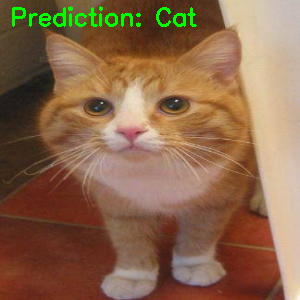

In [32]:
import cv2
import joblib
import numpy as np
from skimage.feature import hog
from skimage import color
from google.colab.patches import cv2_imshow

# Load model
model = joblib.load("knn_hog_cat_dog_model.pkl")
image_size = (64, 64)  # same size used during training

def predict_and_show_colab(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print("⚠️ Could not load image.")
        return

    # Resize and extract HOG features
    resized_img = cv2.resize(img, image_size)
    gray = color.rgb2gray(resized_img)
    features = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), block_norm='L2-Hys')
    features = features.reshape(1, -1)

    # Predict
    prediction = model.predict(features)[0]
    label = "Cat" if prediction == 0 else "Dog"

    # Display image with label using cv2_imshow
    display_img = cv2.resize(img, (300, 300))
    cv2.putText(display_img, f"Prediction: {label}", (10, 25),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    cv2_imshow(display_img)

# 🔍 Example usage
predict_and_show_colab("/content/drive/MyDrive/Dataset/Test/Cat/cat.4973.jpg")


In [33]:
correct = 0
for i in range(len(X_test)):
    pred = knn.predict([X_test[i]])[0]
    true = y_test[i]
    result = "✅" if pred == true else "❌"
    if pred == true:
        correct += 1
    print(f"Image {i+1:02d}: Predicted = {pred}, Actual = {true} {result}")

print(f"\nCalculated Accuracy: {correct}/{len(X_test)} = {correct / len(X_test):.2%}")


Image 01: Predicted = 0, Actual = 0 ✅
Image 02: Predicted = 0, Actual = 0 ✅
Image 03: Predicted = 0, Actual = 0 ✅
Image 04: Predicted = 1, Actual = 0 ❌
Image 05: Predicted = 1, Actual = 0 ❌
Image 06: Predicted = 0, Actual = 0 ✅
Image 07: Predicted = 0, Actual = 0 ✅
Image 08: Predicted = 0, Actual = 0 ✅
Image 09: Predicted = 1, Actual = 0 ❌
Image 10: Predicted = 0, Actual = 0 ✅
Image 11: Predicted = 1, Actual = 0 ❌
Image 12: Predicted = 1, Actual = 0 ❌
Image 13: Predicted = 0, Actual = 0 ✅
Image 14: Predicted = 1, Actual = 0 ❌
Image 15: Predicted = 0, Actual = 0 ✅
Image 16: Predicted = 0, Actual = 0 ✅
Image 17: Predicted = 0, Actual = 0 ✅
Image 18: Predicted = 0, Actual = 0 ✅
Image 19: Predicted = 1, Actual = 0 ❌
Image 20: Predicted = 0, Actual = 0 ✅
Image 21: Predicted = 0, Actual = 0 ✅
Image 22: Predicted = 0, Actual = 0 ✅
Image 23: Predicted = 0, Actual = 0 ✅
Image 24: Predicted = 0, Actual = 0 ✅
Image 25: Predicted = 0, Actual = 0 ✅
Image 26: Predicted = 0, Actual = 0 ✅
Image 27: Pr

In [34]:
import os

# Assuming you have lists of test image paths in the same order as X_test and y_test
# Let's first collect all test image paths for cat and dog, matching the order of features

def get_image_paths(folder):
    # Sort to keep consistent order (important!)
    return sorted([os.path.join(folder, f) for f in os.listdir(folder)])

cat_test_paths = get_image_paths(os.path.join(test_path, "Cat"))
dog_test_paths = get_image_paths(os.path.join(test_path, "Dog"))

# Combine in same order as X_test (cat images first, then dog images)
test_image_paths = cat_test_paths + dog_test_paths

# Now find misclassified images
wrong_images = []

for i, (features, true_label) in enumerate(zip(X_test, y_test)):
    pred_label = knn.predict([features])[0]
    if pred_label != true_label:
        wrong_images.append(test_image_paths[i])

print(f"Total misclassified images: {len(wrong_images)}")
print("Misclassified image filenames:")
for path in wrong_images:
    print(path)


Total misclassified images: 14
Misclassified image filenames:
/content/drive/MyDrive/Dataset/Test/Cat/cat.444.jpg
/content/drive/MyDrive/Dataset/Test/Cat/cat.445.jpg
/content/drive/MyDrive/Dataset/Test/Cat/cat.4974.jpg
/content/drive/MyDrive/Dataset/Test/Cat/cat.4976.jpg
/content/drive/MyDrive/Dataset/Test/Cat/cat.4977.jpg
/content/drive/MyDrive/Dataset/Test/Cat/cat.4979.jpg
/content/drive/MyDrive/Dataset/Test/Cat/cat.4998.jpg
/content/drive/MyDrive/Dataset/Test/Cat/cat.647.jpg
/content/drive/MyDrive/Dataset/Test/Dog/dog.4198.jpg
/content/drive/MyDrive/Dataset/Test/Dog/dog.4205.jpg
/content/drive/MyDrive/Dataset/Test/Dog/dog.4208.jpg
/content/drive/MyDrive/Dataset/Test/Dog/dog.4210.jpg
/content/drive/MyDrive/Dataset/Test/Dog/dog.4212.jpg
/content/drive/MyDrive/Dataset/Test/Dog/dog.4214.jpg


In [35]:
def load_images_sorted(folder, label):
    features = []
    labels = []
    image_paths = []
    for filename in sorted(os.listdir(folder)):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, image_size)
            gray = color.rgb2gray(img)
            hog_feature = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2), block_norm='L2-Hys')
            features.append(hog_feature)
            labels.append(label)
            image_paths.append(img_path)
    return features, labels, image_paths

X_test_cat, y_test_cat, cat_paths = load_images_sorted(os.path.join(test_path, "Cat"), 0)
X_test_dog, y_test_dog, dog_paths = load_images_sorted(os.path.join(test_path, "Dog"), 1)

X_test = np.array(X_test_cat + X_test_dog)
y_test = np.array(y_test_cat + y_test_dog)
test_image_paths = cat_paths + dog_paths


In [36]:
wrong_images = []
for i in range(len(X_test)):
    pred = knn.predict([X_test[i]])[0]
    if pred != y_test[i]:
        wrong_images.append(test_image_paths[i])

print("Misclassified images:")
for w in wrong_images:
    print(w)


Misclassified images:
/content/drive/MyDrive/Dataset/Test/Cat/cat.444.jpg
/content/drive/MyDrive/Dataset/Test/Cat/cat.4974.jpg
/content/drive/MyDrive/Dataset/Test/Cat/cat.4976.jpg
/content/drive/MyDrive/Dataset/Test/Cat/cat.4977.jpg
/content/drive/MyDrive/Dataset/Test/Cat/cat.4978.jpg
/content/drive/MyDrive/Dataset/Test/Cat/cat.4997.jpg
/content/drive/MyDrive/Dataset/Test/Cat/cat.5000.jpg
/content/drive/MyDrive/Dataset/Test/Cat/cat.566.jpg
/content/drive/MyDrive/Dataset/Test/Dog/dog.4196.jpg
/content/drive/MyDrive/Dataset/Test/Dog/dog.4197.jpg
/content/drive/MyDrive/Dataset/Test/Dog/dog.4199.jpg
/content/drive/MyDrive/Dataset/Test/Dog/dog.4208.jpg
/content/drive/MyDrive/Dataset/Test/Dog/dog.4216.jpg
/content/drive/MyDrive/Dataset/Test/Dog/dog.4219.jpg


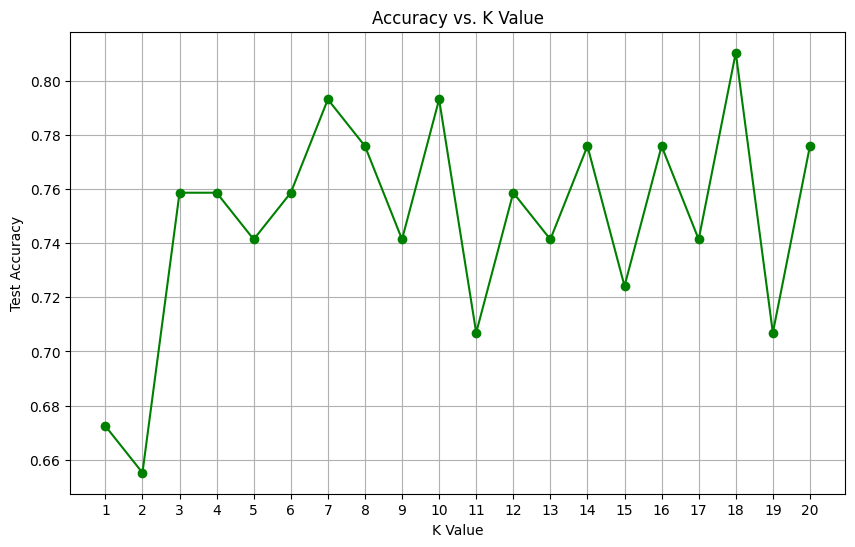

In [37]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

k_values = list(range(1, 21))  # Try K from 1 to 20
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred_k = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred_k)
    accuracies.append(acc)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='green')
plt.title('Accuracy vs. K Value')
plt.xlabel('K Value')
plt.ylabel('Test Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.show()


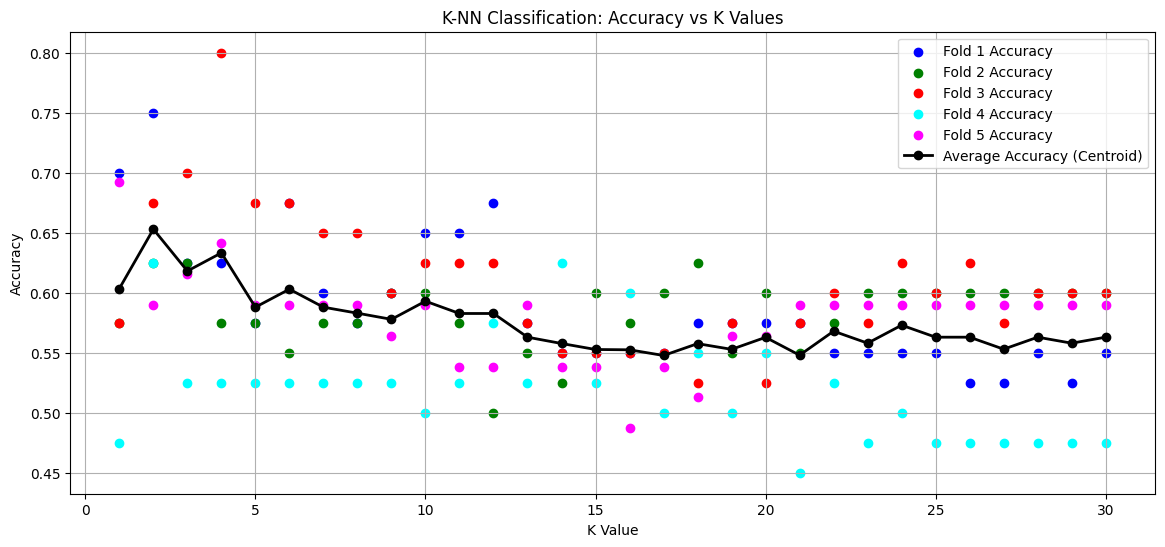

In [38]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Parameters
k_values = list(range(1, 31))  # K values from 1 to 30
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

fold_accuracies = [[] for _ in range(num_folds)]  # Accuracy for each fold
average_accuracies = []  # Mean accuracy for each K

# Loop over K values
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    fold_index = 0
    temp_fold_accuracies = []

    for train_index, val_index in kf.split(X_train):
        X_tr, X_val = X_train[train_index], X_train[val_index]
        y_tr, y_val = y_train[train_index], y_train[val_index]

        knn.fit(X_tr, y_tr)
        y_pred = knn.predict(X_val)
        acc = accuracy_score(y_val, y_pred)

        fold_accuracies[fold_index].append(acc)
        temp_fold_accuracies.append(acc)
        fold_index += 1

    average_accuracies.append(np.mean(temp_fold_accuracies))

# Plot
plt.figure(figsize=(14, 6))
colors = ['blue', 'green', 'red', 'cyan', 'magenta']
for fold in range(num_folds):
    plt.scatter(k_values, fold_accuracies[fold], color=colors[fold], label=f'Fold {fold+1} Accuracy')

# Plot average accuracy line
plt.plot(k_values, average_accuracies, color='black', marker='o', linewidth=2, label='Average Accuracy (Centroid)')

# Decorate plot
plt.title("K-NN Classification: Accuracy vs K Values")
plt.xlabel("K Value")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()
